In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Plot colours and themes

In [2]:
sns.set_context("talk")

In [3]:
# Choose the colorblind palette
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
col = sns.color_palette("colorblind").as_hex()

## Summary statistics

In [5]:
# Read data
df = pd.read_csv("../outputs/omim_phenotypes_in_constrained_regions.tsv", sep="\t")

# Convert phenotypes to boolean
df["phenotype"] = df["phenotype"].fillna(False)
df.loc[df["phenotype"] != False, "phenotype"] = True

# Limit to relevant columns
df = df[["ensg", "region", "constraint", "phenotype", "inheritance"]]

# Drop duplicates
df = df.drop_duplicates()

# Exclude start-proximal regions, which are uninformative
df = df[df["region"] != "start_proximal"]

print("Region value counts:")
print(df.region.value_counts())

Region value counts:
transcript    12673
distal_nmd    12070
nmd_target     9912
long_exon      1962
Name: region, dtype: int64


## Fraction of genes which are OMIM morbid

### Format data

In [6]:
# Proportion of genes with a phenotype
_a = df.groupby(["constraint", "region"])["phenotype"].value_counts(normalize=True)

# Inheritance mode for genes with a phenotype
_b = df.groupby(["constraint", "region", "phenotype"])["inheritance"].value_counts(
    normalize=True
)
# Number of unique genes in each region / constraint category
_c = df.groupby(["region", "constraint"])["ensg"].nunique().rename("n")

# Absolute proportion of inheritance mode, for genes with a phenotype
df1 = (_a * _b).dropna().rename("abs_proportion")

# Add gene counts
df1 = df1.to_frame()  # Allows merging
df1 = df1.merge(_c, left_index=True, right_index=True)  # Add gene counts
df1 = df1.reset_index(drop=False)

# Clean label text
df1 = df1.replace(
    {
        "constrained": "Constrained",
        "unconstrained": "Unconstrained",
        "distal_nmd": "Distal",
        "long_exon": "Long exon",
        "nmd_target": "NMD target",
        "transcript": "Transcript",
    }
)

### Plot

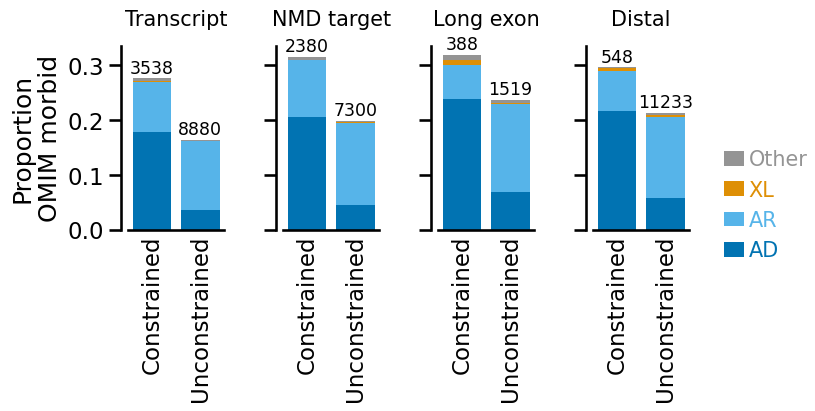

In [59]:
fig, axs = plt.subplots(1, 4, sharey=True, layout="constrained", figsize=(8, 4))

regions = ["Transcript", "NMD target", "Long exon", "Distal"]
inheritance = df1.inheritance.unique()
colours = [col[0], col[-1], col[1], col[-3]]
ticks = np.arange(df1["constraint"].nunique())

for ax, r in zip(axs, regions):
    d = df1[df1["region"] == r]
    bottom = np.zeros(len(ticks))

    for i, c in zip(inheritance, colours):
        _d = d[d["inheritance"] == i]
        b = ax.bar(
            x=ticks,
            height=_d["abs_proportion"],
            label=_d["inheritance"],
            color=c,
            bottom=bottom,
        )
        bottom += list(_d["abs_proportion"])

    ax.set_xticks(
        ticks=ticks,
        labels=_d["constraint"],
        rotation=90,
        # ha="right",
        # rotation_mode="anchor",
    )

    ax.set_title(r, size="small", loc="center", pad=15)
    ax.tick_params(axis="x", length=0)
    ax.set_yticks(
        ticks=[0, 0.1, 0.2, 0.3],
    )
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))

    # Add bar labels
    for i, n in enumerate(_d["n"]):
        y_offset = 0.01
        ax.text(x=ticks[i], y = bottom[i] + y_offset, s=n, fontsize="x-small", ha="center",)

axs[0].set_ylabel("Proportion\nOMIM morbid")

fig.get_layout_engine().set(wspace=0.2)

fig.legend(
    [
        axs[0].get_children()[x]
        for x in [
            0,
            2,
            4,
            6,
        ]
    ][::-1],
    [
        "Other",
        "XL",
        "AR",
        "AD",
    ],
    fontsize="small",
    frameon=False,
    labelcolor="linecolor",
    loc="outside right center",
    handlelength=1,
    handletextpad=0.2,
    borderaxespad=0,
)

plt.savefig("../plots/omim_morbid_constrained_regions.svg", format="svg")